In [9]:
!pip install scikit-learn xgboost


   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/8.9 MB 1.1 MB/s eta 0:00:08
    --------------------------------------- 0.2/8.9 MB 1.8 MB/s eta 0:00:05
   - -------------------------------------- 0.3/8.9 MB 2.1 MB/s eta 0:00:05
   -- ------------------------------------- 0.6/8.9 MB 2.7 MB/s eta 0:00:04
   -- ------------------------------------- 0.6/8.9 MB 2.5 MB/s eta 0:00:04
   --- ------------------------------------ 0.8/8.9 MB 2.7 MB/s eta 0:00:04
   ---- ----------------------------------- 0.9/8.9 MB 2.7 MB/s eta 0:00:03
   ----- ---------------------------------- 1.2/8.9 MB 2.9 MB/s eta 0:00:03
   ------ --------------------------------- 1.4/8.9 MB 3.0 MB/s eta 0:00:03
   ------- -------------------------------- 1.6/8.9 MB 3.2 MB/s eta 0:00:03
   -------- ------------------------------- 1.9/8.9 MB 3.5 MB/s eta 0:00:03
   --------- -------------


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\vinic\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
# =============================================================================
# BLOCO 6: VERIFICAÇÃO E PLOTAGEM DA DISTRIBUIÇÃO DAS CLASSES
# =============================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 1. CARREGAR OS DADOS ---

# Caminho onde os CSVs foram salvos (ajuste se for diferente)
caminho_base_output = r'C:\Users\vinic\OneDrive\Documentos\Graduação\TG\Dataset\TCC'
caminho_csv_treino = os.path.join(caminho_base_output, 'df_treino_features.csv')
caminho_csv_teste = os.path.join(caminho_base_output, 'df_teste_features.csv')

try:
    df_treino = pd.read_csv(caminho_csv_treino)
    df_teste = pd.read_csv(caminho_csv_teste)
    print("Arquivos CSV carregados com sucesso!")
except FileNotFoundError:
    print(f"ERRO: Arquivos CSV não encontrados no caminho: {caminho_base_output}")
    print("Verifique se o Bloco 4 foi executado e os arquivos estão no local correto.")
    # Se der erro aqui, não continue o script
    raise

# Coluna alvo
target_column = 'tipo_falha_adicionada'

# --- 2. CONTAR AMOSTRAS (TEXTO) ---

print("\n" + "="*40)
print("  CONTAGEM DE AMOSTRAS - CONJUNTO DE TREINO")
print("="*40)
counts_treino = df_treino[target_column].value_counts().sort_index()
print(counts_treino)


print("\n" + "="*40)
print("  CONTAGEM DE AMOSTRAS - CONJUNTO de TESTE")
print("="*40)
counts_teste = df_teste[target_column].value_counts().sort_index()
print(counts_teste)
print("\n")


# Lista das estatísticas que queremos ver
stats_para_mostrar = ['mean', 'std', 'min', 'max']

print("\n--- ESTATÍSTICAS DO TREINO (SINTÉTICO) ---")
# Usamos .loc[stats_para_mostrar] para filtrar o resultado
print(X_treino.describe().loc[stats_para_mostrar])

print("\n--- ESTATÍSTICAS DO TESTE (REAL) ---")
# Usamos .loc[stats_para_mostrar] para filtrar o resultado
print(X_teste.describe().loc[stats_para_mostrar])

Arquivos CSV carregados com sucesso!

  CONTAGEM DE AMOSTRAS - CONJUNTO DE TREINO
tipo_falha_adicionada
Esfera           5640
Normal            470
Pista Externa    5640
Pista Interna    5640
Name: count, dtype: int64

  CONTAGEM DE AMOSTRAS - CONJUNTO de TESTE
tipo_falha_adicionada
Esfera            997
Normal            115
Pista Externa     750
Pista Interna    1035
Name: count, dtype: int64



--- ESTATÍSTICAS DO TREINO (SINTÉTICO) ---
       TF2_std   TF3_rms  TF4_fator_forma  FF2_freq_central  FF3_rms_freq  \
mean  0.228391  0.229076         1.194849        952.788752   1445.733928   
std   0.232669  0.232331         0.054777        155.580217    127.633027   
min   0.059901  0.061651         1.110302        457.940606    907.070602   
max   0.724300  0.724434         1.272933       1214.277092   1705.413307   

      FF5_assimetria_espectral  FF_pico_50_200Hz  
mean                  2.030968        110.191406  
std                   0.380111         36.565723  
min              

Arquivos CSV carregados com sucesso!
Amostras de Treino: 11750, Amostras de Teste: 2897

Classes (alvo) codificadas: ['Esfera', 'Normal', 'Pista Externa', 'Pista Interna']

Pré-processamento concluído: LabelEncoder e StandardScaler aplicados.

--- INICIANDO TREINAMENTO DOS MODELOS ---
Treinando QDA...
Treinando SVM...


C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing 

Treinando XGBoost...
--- TREINAMENTO CONCLUÍDO ---

--- AVALIAÇÃO DOS MODELOS NO CONJUNTO DE TESTE ---

  Resultados para o modelo: QDA
Acurácia: 0.8381 (ou 83.81%)

Relatório de Classificação:
               precision    recall  f1-score   support

       Esfera       0.74      0.96      0.84       997
       Normal       1.00      1.00      1.00       115
Pista Externa       0.91      0.73      0.81       750
Pista Interna       0.91      0.78      0.84      1035

     accuracy                           0.84      2897
    macro avg       0.89      0.87      0.87      2897
 weighted avg       0.86      0.84      0.84      2897

Matriz de Confusão:


C:\Users\vinic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:199: UserWarning: [19:08:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


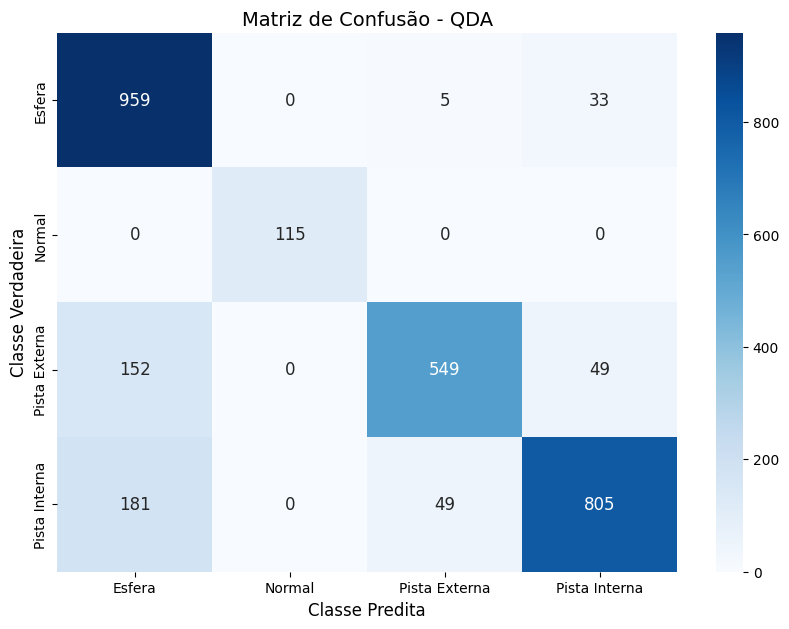


--- Verificando Acurácia no TREINO para QDA ---
Acurácia no TREINO: 83.81%
-> Modelo NEM SEQUER aprendeu os dados sintéticos (Problema maior)

  Resultados para o modelo: SVM
Acurácia: 0.8236 (ou 82.36%)

Relatório de Classificação:
               precision    recall  f1-score   support

       Esfera       0.80      0.85      0.82       997
       Normal       1.00      1.00      1.00       115
Pista Externa       0.99      0.73      0.84       750
Pista Interna       0.75      0.85      0.80      1035

     accuracy                           0.82      2897
    macro avg       0.89      0.86      0.86      2897
 weighted avg       0.84      0.82      0.82      2897

Matriz de Confusão:


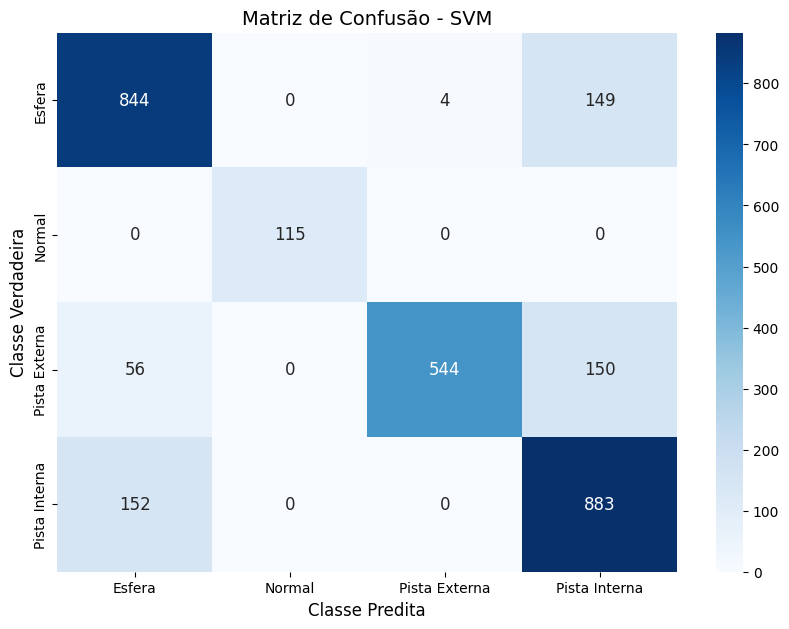


--- Verificando Acurácia no TREINO para SVM ---
Acurácia no TREINO: 82.36%
-> Modelo NEM SEQUER aprendeu os dados sintéticos (Problema maior)

  Resultados para o modelo: XGBoost
Acurácia: 1.0000 (ou 100.00%)

Relatório de Classificação:
               precision    recall  f1-score   support

       Esfera       1.00      1.00      1.00       997
       Normal       1.00      1.00      1.00       115
Pista Externa       1.00      1.00      1.00       750
Pista Interna       1.00      1.00      1.00      1035

     accuracy                           1.00      2897
    macro avg       1.00      1.00      1.00      2897
 weighted avg       1.00      1.00      1.00      2897

Matriz de Confusão:


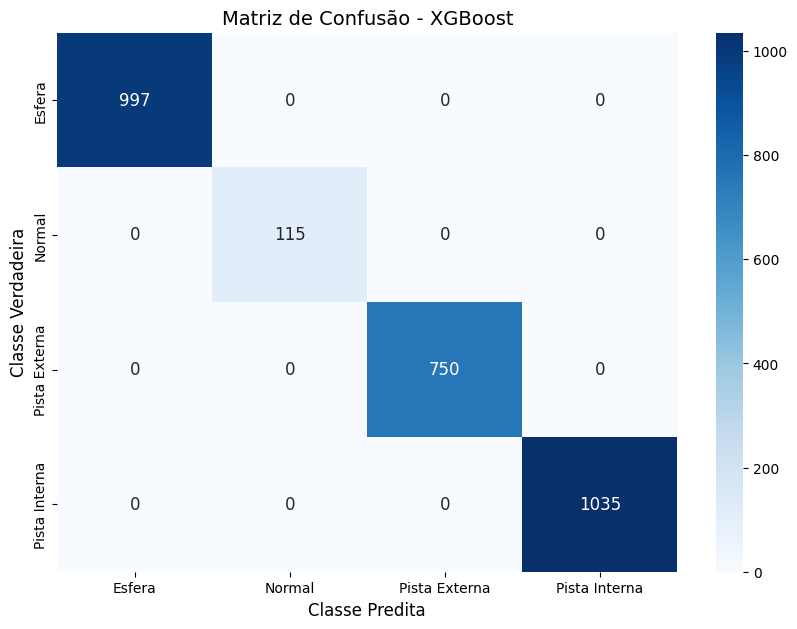


--- Verificando Acurácia no TREINO para XGBoost ---
Acurácia no TREINO: 100.00%
-> Modelo aprendeu os dados sintéticos (Isso é o esperado)


In [ ]:
# =============================================================================
# BLOCO 5: TREINAMENTO E AVALIAÇÃO DOS MODELOS (QDA, SVM, XGBOOST)
# =============================================================================

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- 1. CARREGAR OS DADOS ---

# Caminho onde os CSVs foram salvos (ajuste se for diferente)
caminho_base_output = r'C:\Users\vinic\OneDrive\Documentos\Graduação\TG\Dataset\TCC'
caminho_csv_treino = os.path.join(caminho_base_output, 'df_treino_features.csv')
caminho_csv_teste = os.path.join(caminho_base_output, 'df_teste_features.csv')

try:
    df_treino = pd.read_csv(caminho_csv_treino)
    df_teste = pd.read_csv(caminho_csv_teste)
    print("Arquivos CSV carregados com sucesso!")
    print(f"Amostras de Treino: {len(df_treino)}, Amostras de Teste: {len(df_teste)}")
except FileNotFoundError:
    print(f"ERRO: Arquivos CSV não encontrados no caminho: {caminho_base_output}")
    print("Verifique se o Bloco 4 foi executado e os arquivos estão no local correto.")
    # Se der erro aqui, não continue o script
    raise

# --- 2. PREPARAÇÃO DOS DADOS (PRÉ-PROCESSAMENTO) ---

# Definir colunas de features e a coluna alvo
# (Baseado na saída do Bloco 3)
feature_columns = [
    'TF2_std', 'TF3_rms', 'TF4_fator_forma',
    'FF2_freq_central', 'FF3_rms_freq', 'FF5_assimetria_espectral',
    'FF_pico_50_200Hz'
]
target_column = 'tipo_falha_adicionada'

# Separar X (features) e y (alvo)
X_treino = df_treino[feature_columns]
y_treino = df_treino[target_column]

X_teste = df_teste[feature_columns]
y_teste = df_teste[target_column]

# --- 2a. Label Encoding (para a variável alvo 'y') ---
# Modelos precisam de alvos numéricos (ex: 0, 1, 2) em vez de ('Normal', 'Esfera', ...)
le = LabelEncoder()
y_treino_encoded = le.fit_transform(y_treino)
y_teste_encoded = le.transform(y_teste) # Usa o 'transform' para garantir a mesma ordem

# Salvar os nomes das classes para os relatórios
class_names = le.classes_
print(f"\nClasses (alvo) codificadas: {list(class_names)}")

# --- 2b. Feature Scaling (para as features 'X') ---
# (Importante para SVM e QDA)
scaler = StandardScaler()
X_treino_scaled = scaler.fit_transform(X_treino)
X_teste_scaled = scaler.transform(X_teste) # Apenas 'transform' no teste (evita data leakage)

print("\nPré-processamento concluído: LabelEncoder e StandardScaler aplicados.")

# --- 3. DEFINIÇÃO E TREINAMENTO DOS MODELOS ---

# Dicionário com os modelos a serem treinados
models = {
    'QDA': QuadraticDiscriminantAnalysis(),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Dicionário para armazenar os modelos treinados
trained_models = {}

print("\n--- INICIANDO TREINAMENTO DOS MODELOS ---")
for name, model in models.items():
    print(f"Treinando {name}...")
    model.fit(X_treino_scaled, y_treino_encoded)
    trained_models[name] = model
print("--- TREINAMENTO CONCLUÍDO ---")

# --- 4. AVALIAÇÃO DOS MODELOS NO CONJUNTO DE TESTE ---

print("\n--- AVALIAÇÃO DOS MODELOS NO CONJUNTO DE TESTE ---")

for name, model in trained_models.items():
    # Fazer predições no conjunto de teste
    y_pred = model.predict(X_teste_scaled)
    
    # Calcular Acurácia
    accuracy = accuracy_score(y_teste_encoded, y_pred)
    
    print(f"\n=======================================================")
    print(f"  Resultados para o modelo: {name}")
    print(f"=======================================================")
    print(f"Acurácia: {accuracy:.4f} (ou {accuracy*100:.2f}%)")
    
    # Exibir Relatório de Classificação
    print("\nRelatório de Classificação:")
    print(classification_report(y_teste_encoded, y_pred, target_names=class_names, zero_division=0))
    
    # Exibir Matriz de Confusão
    print("Matriz de Confusão:")
    cm = confusion_matrix(y_teste_encoded, y_pred)
    
    # Plotar a Matriz de Confusão
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                annot_kws={"size": 12}) # Aumenta o tamanho da fonte
    plt.xlabel('Classe Predita', fontsize=12)
    plt.ylabel('Classe Verdadeira', fontsize=12)
    plt.title(f'Matriz de Confusão - {name}', fontsize=14)
    plt.show()

    # =================================================================
    # VERIFICAÇÃO: Testando a performance no PRÓPRIO CONJUNTO DE TREINO
    # =================================================================
    print(f"\n--- Verificando Acurácia no TREINO para {name} ---")
    y_pred_treino = model.predict(X_treino_scaled)
    accuracy_treino = accuracy_score(y_treino_encoded, y_pred_treino)
    print(f"Acurácia no TREINO: {accuracy_treino*100:.2f}%")
    
    if accuracy_treino > 0.95:
        print("-> Modelo aprendeu os dados sintéticos (Isso é o esperado)")
    else:
        print("-> Modelo NEM SEQUER aprendeu os dados sintéticos (Problema maior)")
    # =================================================================